# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M = 2                # the population has two age groups
N = 1e6              # and this is the total population

# parameters for generating synthetic trajectory 
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
# C_ij = number of people group from group i that an individual from group j meets per day 

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([2, 2])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

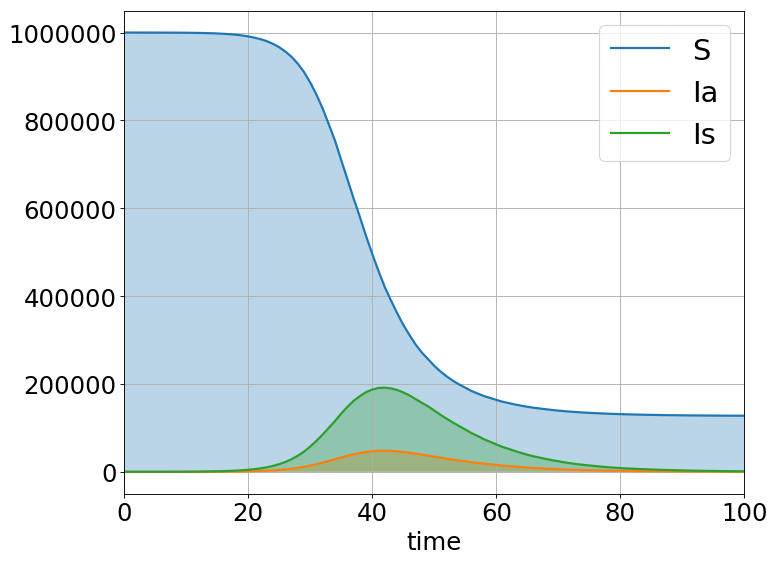

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the trajectories and use it to infer the parameters of the model.

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x)[:Nf_inference]

estimator = pyross.inference.SIR(parameters, M, Ni)

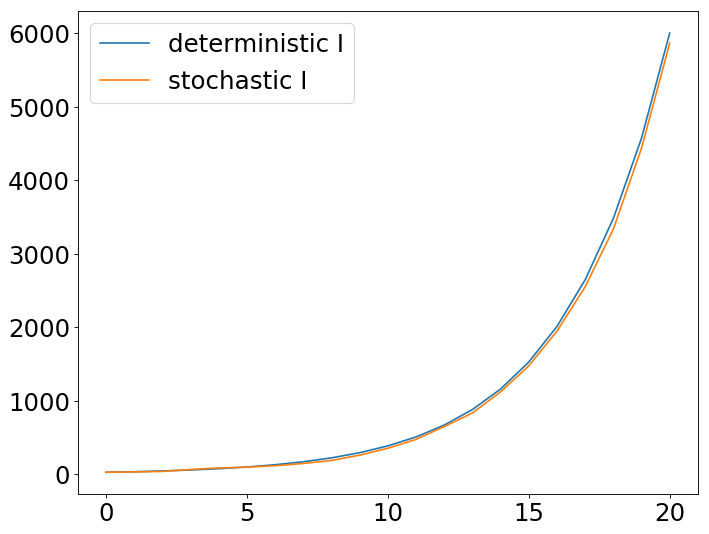

In [5]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use faster ODE methods to speed up inference 
estimator.set_lyapunov_method('RK2')
estimator.set_det_method('euler')

logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=False)
end_time = time.time()
print(logp) 
print(end_time - start_time)

388.3304018771075
0.03829622268676758


In [7]:
# compare to tangent space 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

406.53511757831706
0.010780811309814453


In [8]:
# Define the prior (log normal prior around guess of parameter with defined std. deviation)
alpha_g = 0.25
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.1


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix)
print(logp) 

1710.0195871663987


In [9]:
# Set up priors 
eps = 1e-4
priors = {
    'alpha':{
        'mean': alpha_g, 
        'std': 0.2, 
        'bounds': [eps, 0.8]
    }, 
    'beta':{
        'mean': beta_g, 
        'std': 0.1, 
        'bounds': [eps, 0.2]
    }, 
    'gIa':{
        'mean': gIa_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': gIs_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }
}

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
res = estimator.infer_parameters(x, Tf_inference, contactMatrix, priors, tangent=False, 
                                    global_max_iter=20, local_max_iter=400,
                                    cma_population=32, global_atol=10,
                                    ftol=ftol, verbose=True)
end_time = time.time()

print(res['map_dict']) # best guess 
print(end_time - start_time)

Starting global minimisation...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 4 (seed=3618765821, Thu Jul  2 10:10:23 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 1.389240658987424e+03 1.0e+00 8.70e-01  5e-02  2e-01 0:00.9
    2     64 4.545897276644052e+02 1.2e+00 1.05e+00  5e-02  2e-01 0:01.7
    3     96 9.369482745826003e+02 1.8e+00 8.91e-01  3e-02  2e-01 0:02.4
    9    288 3.790333183720035e+02 5.2e+00 5.30e-01  5e-03  1e-01 0:05.7
   15    480 3.698500639975422e+02 1.3e+01 2.49e-01  8e-04  3e-02 0:09.8
Optimal value (global minimisation):  368.94715731642424
Starting local minimisation...
Optimal value (local minimisation):  368.9072857766879
{'alpha': 0.1806441336750157, 'beta': 0.021176961448913623, 'gIa': 0.10374595043379255, 'gIs': 0.16040751062071953, 'fsa': array([1., 1.])}
14.066030025482178


In [10]:
# compute log_p for best estimate 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(res['map_dict'], x, Tf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

373.66304464258354
0.03334975242614746


In [11]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(res['map_dict'])

print(res['flat_map'])

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

Inferred parameters:
{'alpha': 0.1806441336750157, 'beta': 0.021176961448913623, 'gIa': 0.10374595043379255, 'gIs': 0.16040751062071953, 'fsa': array([1., 1.])}
[0.18064413 0.02117696 0.10374595 0.16040751]


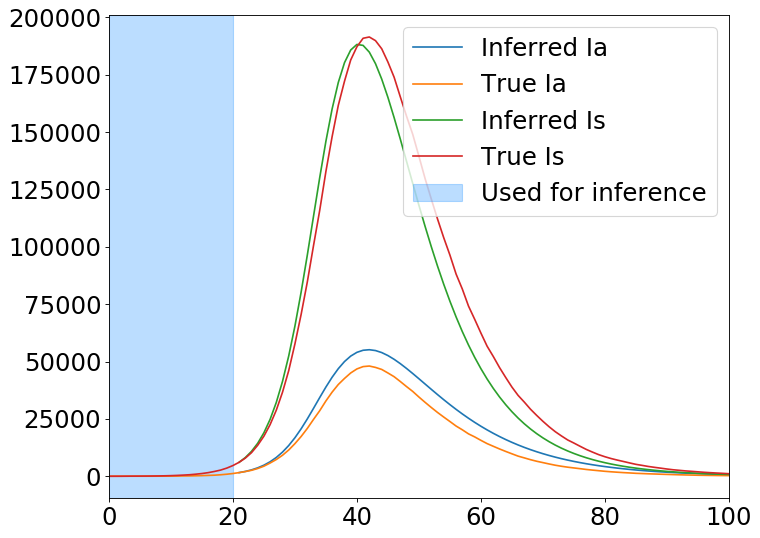

In [12]:
x = np.load('SIR_sto_traj.npy').astype('float')
Nf = x.shape[0]
Tf = Nf-1

# set the deterministic method to be solve_ivp for accurate integration over long time scale 
estimator.set_det_method('LSODA')
estimator.set_det_model(res['map_dict'])
estimator.set_params(res['map_dict'])

x_det = estimator.integrate(x[Nf_inference], Nf_inference, Tf, Nf-Nf_inference)
t_inf = np.linspace(Nf_inference, Tf, Nf-Nf_inference)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
# plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
# plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(t_inf, np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(t_inf, np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 

In [13]:
eps = 1e-3
x = np.load('SIR_sto_traj.npy').astype('float')[:Nf_inference]
hess = estimator.compute_hessian(x, Tf_inference, contactMatrix, res, eps=eps, tangent=False,
                                 fd_method="central")

In [14]:
cov = np.linalg.inv(hess)
print(cov)
v, w = np.linalg.eig(cov)
print(v)

[[ 2.85095885e-04 -7.74869929e-08  5.89080310e-04 -1.49799951e-04]
 [-7.74869929e-08  5.37934491e-08 -1.62948759e-07  4.85658094e-08]
 [ 5.89080310e-04 -1.62948759e-07  1.32370719e-03 -3.29806281e-04]
 [-1.49799951e-04  4.85658094e-08 -3.29806281e-04  9.44218086e-05]]
[1.67282931e-03 1.91802357e-05 1.12153613e-05 5.37677810e-08]
